In [55]:
#Importing necessary Libraries.

from itertools import count
import pandas as pd
import numpy as np
import pickle
import numpy as np
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report as creport

import json
import csv
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl
import joblib 

import streamlit as st 

from cProfile import label
from email.policy import default
import functools
from locale import D_FMT

from sklearn.svm import SVC

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from sklearn.metrics import confusion_matrix
import seaborn as sns 
import numpy as np

import warnings
warnings.filterwarnings('always')

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Getting the training dataset from Sparql DBMS 

In [56]:
# Getting the training dataset from Sparql DBMS 

def sparql_query() -> pd.DataFrame:
    ssl._create_default_https_context = ssl._create_unverified_context
    sparql = SPARQLWrapper(
    "https://linked.aub.edu.lb:8080/fuseki/actionrec_ml/"
    )

    sparql.setQuery("""
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX oa: <http://www.w3.org/ns/oa#>  
    PREFIX dcterms: <http://purl.org/dc/terms/>  
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>  
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#type/>  
    PREFIX schema: <http://schema.org/>  
    PREFIX arec: <http://linked.aub.edu.lb/actionrec/>   
 
    SELECT ?productName ?product ?action ?agent ?environment ?feature ?object ?reviewBody ?rating ?valence  ?annotationDescription ?annotationLabel ?annotation ?AnnotationCreationDate
    WHERE {   
    ?product schema:potentialAction ?action .  
    ?product dcterms:isPartOf ?annotation .  
    ?product schema:name ?productName .  
    ?action dcterms:isPartOf ?annotation .  
    ?agent dcterms:isPartOf ?annotation . 
    ?environment dcterms:isPartOf ?annotation .  
    ?feature dcterms:isPartOf ?annotation .  
    ?object  dcterms:isPartOf ?annotation .
    ?action schema:agent ?agent . 
    ?action schema:object ?object . 
    ?action schema:location ?environment . 
    ?product arec:hasFeature ?feature . 
    ?annotation oa:hasTarget ?review . 
    ?review schema:reviewBody ?reviewBody . 
    ?review schema:reviewRating ?review_rating . 
    ?review_rating schema:ratingValue ?rating .
    ?annotation rdf:subClassOf oa:Annotation . 
    ?annotation arec:hasValence ?valence .
    ?annotation schema:description ?annotationDescription .
    ?annotation rdfs:label ?annotationLabel .
    ?annotation dct:created ?AnnotationCreationDate
   }  
   ORDER BY ?productName
       """
   )

    
    sparql.setOnlyConneg(True)
    sparql.setReturnFormat(JSON)


    ret = sparql.query().convert()
    list_name = []
    list_product=[]
    list_action = []
    list_agent = []
    list_object = []
    list_environment = []
    list_feature = []
    list_reviewBody = []
    list_rating = []
    list_valence = []
    list_annotation_desc = []
    list_annotation_label  = []
    list_annotation = []
    list_annotation_date = []

    for item in ret["results"]["bindings"]:
         list_name.append(item['productName']["value"])
         list_product.append(item['product']["value"])
         list_action.append(item['action']["value"])
         list_object.append(item['object']["value"])
         list_agent.append(item['agent']["value"])
         list_environment.append(item["environment"]["value"])
         list_feature.append(item["feature"]["value"])
         list_reviewBody.append(item["reviewBody"]["value"])
         list_rating.append(item["rating"]["value"])
         list_valence.append(item["valence"]["value"])
         list_annotation_desc.append(item["annotationDescription"]["value"])
         list_annotation_label.append(item["annotationLabel"]["value"])
         list_annotation.append(item["annotation"]["value"])
         list_annotation_date.append(item["AnnotationCreationDate"]["value"])

    df_train = pd.DataFrame(list(zip(list_name, list_product,
        list_action, list_agent, list_environment, list_feature, list_object, list_reviewBody, 
        list_rating, list_valence, list_annotation_desc, list_annotation_label, list_annotation, list_annotation_date)), columns = ["Product Name", "Product id", "Action", "Agent", 
        "Environment", "Feature", "Object", "Review Body", "Rating", "Valence", "Annotation Description", "Annotation Label", "Annotation", "Annotation Date"]) 
    
    df_train["Agent"] = df_train["Agent"].str.replace("http://linked.aub.edu.lb/actionrec/Agent/", "")
    df_train["Environment"] = df_train["Environment"].str.replace("http://linked.aub.edu.lb/actionrec/Environment/", "")
    df_train["Object"] = df_train["Object"].str.replace("http://linked.aub.edu.lb/actionrec/Thing/", "")
    
    return df_train


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
df_train = sparql_query()

df_train.to_csv("Training Set.csv")

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-56-6f5d3793e9d6>:89: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Agent"] = df_train["Agent"].str.replace("http://linked.aub.edu.lb/actionrec/Agent/", "")
<ipython-input-56-6f5d3793e9d6>:90: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Environment"] = df_train["Environment"].str.replace("http://linked.aub.edu.lb/actionrec/Environment/", "")
<ipython-input-56-6f5d3793e9d6>:91: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Obje

In [63]:
model_version = "version_2"
label = "ACTION"
accuracy = 0.95


sql = "INSERT INTO `ML_models` (model_version, label, accuracy) VALUES ("+ model_version + "," + label + "," + str(accuracy) + ")"
print(sql)





INSERT INTO `ML_models` (model_version, label, accuracy) VALUES (version_2,ACTION,0.95)


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Preprocessing 

In [83]:
# Preprocess the training set 
def preprocess_text(x):
    
    #x = df_train[["Review Body"]]

    #x=x.iloc[:,0]
    #y=y.iloc[:,:]
    #X=x.to_dict()
    X=list(x) 

    count_vect=CountVectorizer()
    tfidf_transformer = TfidfTransformer()
    X_train_counts=count_vect.fit_transform(X)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_train_tfidf= X_train_tfidf.toarray()

    return X_train_tfidf, count_vect, tfidf_transformer

# preprocess the testing set ( new reveiws )
def count_vectorizer(X_test, count_vect, tfidf_transformer) -> float:
    
    annotation_counts=count_vect.transform(X_test)
    annotation_tfidf = tfidf_transformer.fit_transform(annotation_counts)
    annotation_tfidf= annotation_tfidf.toarray()
    return annotation_tfidf

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:


df_train = sparql_query()

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
# View the training set 

#print(df_train)
print("The training set has rows:", df_train.shape[0], "and columns:", df_train.shape[1])
print("The list of fields in the traing set are:", df_train.columns)

The training set has rows: 3278 and columns: 14
The list of fields in the traing set are: Index(['Product Name', 'Product id', 'Action', 'Agent', 'Environment',
       'Feature', 'Object', 'Review Body', 'Rating', 'Valence',
       'Annotation Description', 'Annotation Label', 'Annotation',
       'Annotation Date'],
      dtype='object')


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Agent Detection Model and Analysis section

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Agent Distribution in Training Dataset'}>

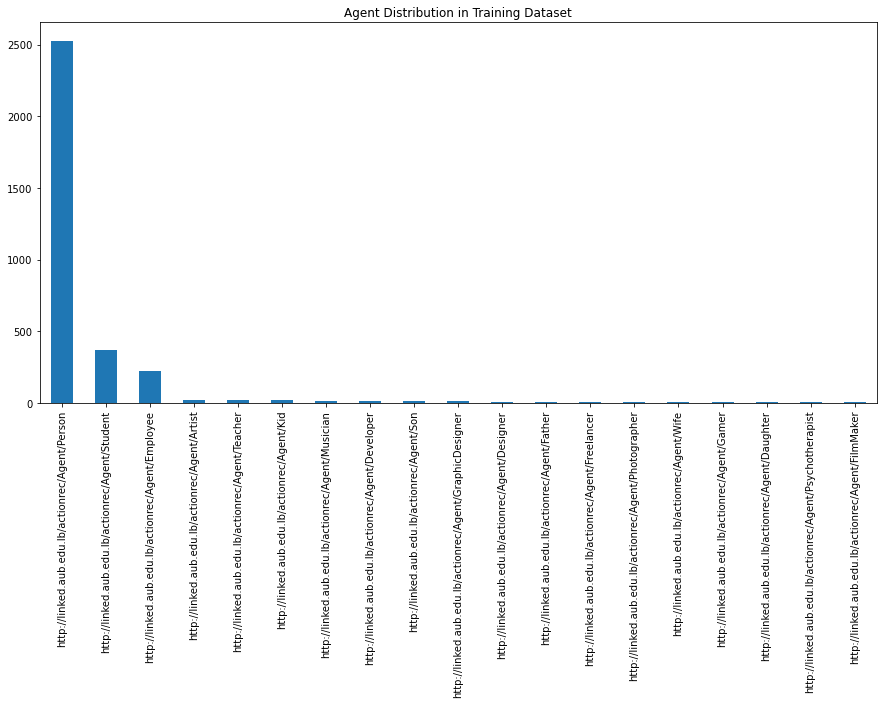

In [86]:
# Agent field analysis 

from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
df_train["Agent"].value_counts().plot(kind="bar", title="Agent Distribution in Training Dataset")


In [87]:
# Train the agent detection model with a split 80%, 20% and observe. 

df_train["Agent"] = df_train["Agent"].str.replace("http://linked.aub.edu.lb/actionrec/Agent/", "")

x = df_train[["Review Body"]]
y = df_train[["Agent"]]
    
x=x.iloc[:,0]
y=y.iloc[:,:]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state =1, shuffle = True)

X_train_tfidf, count_vect, tfidf_transformer = preprocess_text(x_train)
clf= SVC(random_state = 0)
clf.fit(X_train_tfidf, y_train.values)
acc = clf.score(X_train_tfidf, y_train.values)
print("Accuracy for agent detection model on training set (80% of total dataset) is :", acc)
    

x_test_tfidf = count_vectorizer(x_test, count_vect, tfidf_transformer)
print("The full report for the agent detection model on testing set ( 20% of the dataset ) is the below:")
y_pred_agent = clf.predict(x_test_tfidf)
print(creport(y_test, y_pred_agent))
    
    
filename_clf = 'SVM_agent_model_2.sav'
pickle.dump(clf, open(filename_clf, 'wb'))
    


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-87-53b2296e5991>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Agent"] = df_train["Agent"].str.replace("http://linked.aub.edu.lb/actionrec/Agent/", "")
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for agent detection model on training set (80% of total dataset) is : 0.956140350877193
The full report for the agent detection model on testing set ( 20% of the dataset ) is the below:
                 precision    recall  f1-score   support

         Artist       1.00      1.00      1.00         4
       Designer       1.00      1.00      1.00         4
      Developer       1.00      1.00      1.00         4
       Employee       0.87      0.60      0.71        43
         Father       0.00      0.00      0.00         2
          Gamer       1.00      1.00      1.00         2
GraphicDesigner       1.00      0.33      0.50         3
            Kid       0.71      0.71      0.71         7
       Musician       1.00      0.50      0.67         4
         Person       0.94      0.98      0.96       521
   Photographer       1.00      1.00      1.00         1
Psychotherapist       1.00      1.00      1.00         1
            Son       1.00      1.00      1.00         2
      

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipytho

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Confusion matrix of Agent Predictions - SVM Model')

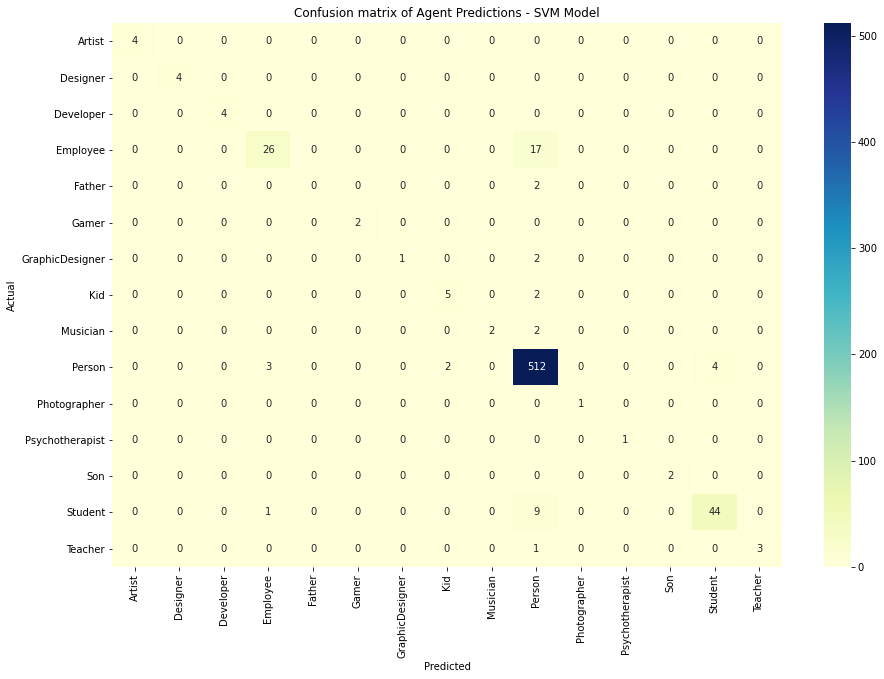

In [88]:
# Error Analysis 

conf_mat_agent = confusion_matrix(y_test, y_pred_agent, labels=np.unique(y_test))
conf_mat_agent

cm = pd.DataFrame(conf_mat_agent, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(cm, cmap="YlGnBu", annot= True, fmt='', ax=ax)
plt.title('Confusion matrix of Agent Predictions - SVM Model')

# Environemnt Detection Model and Analysis 

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Environment Distribution in Training Dataset'}>

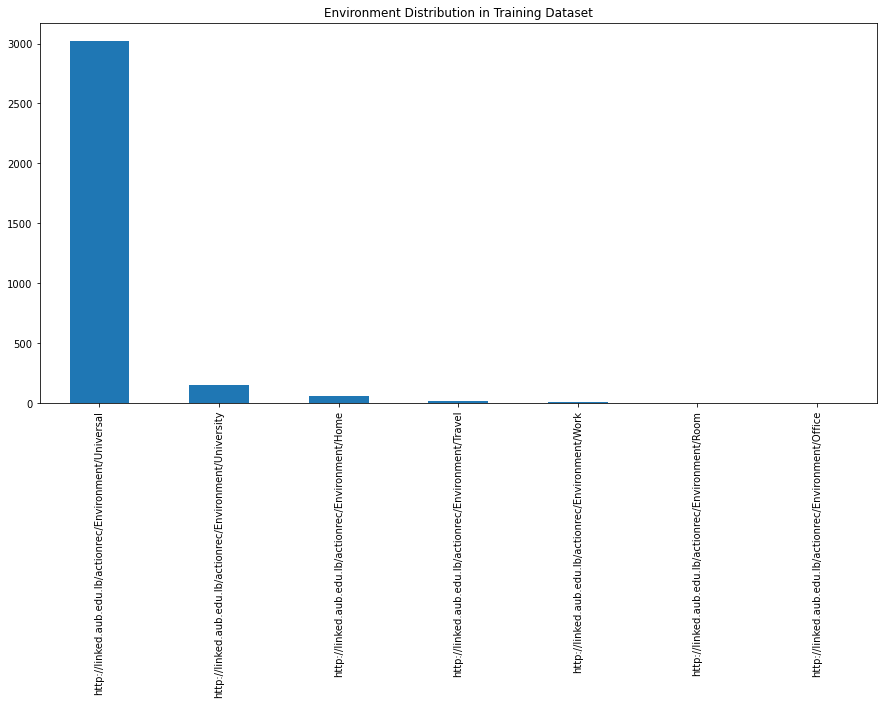

In [89]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
df_train["Environment"].value_counts().plot(kind="bar", title="Environment Distribution in Training Dataset")


In [90]:
# Environment Detection Model

df_train["Environment"] = df_train["Environment"].str.replace("http://linked.aub.edu.lb/actionrec/Environment/", "")

x = df_train[["Review Body"]]
y = df_train[["Environment"]]
    
x=x.iloc[:,0]
y=y.iloc[:,:]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state =1, shuffle = True)

#X_train_tfidf, count_vect, tfidf_transformer = preprocess_text(x_train)
clf= SVC(random_state = 0)
clf.fit(X_train_tfidf, y_train.values)
acc = clf.score(X_train_tfidf, y_train.values)
print("Accuracy for Environment detection model on training set (80% of total dataset) is :", acc)
    

x_test_tfidf = count_vectorizer(x_test, count_vect, tfidf_transformer)
print("The full report for the Environment detection model on testing set ( 20% of the dataset ) is the below:")
y_pred_env = clf.predict(x_test_tfidf)
print(creport(y_test, y_pred_env))
    
    
filename_clf = 'SVM_environment_model_2.sav'
pickle.dump(clf, open(filename_clf, 'wb'))

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-90-3ceafc143c6c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Environment"] = df_train["Environment"].str.replace("http://linked.aub.edu.lb/actionrec/Environment/", "")
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for Environment detection model on training set (80% of total dataset) is : 0.9862700228832952
The full report for the Environment detection model on testing set ( 20% of the dataset ) is the below:
              precision    recall  f1-score   support

        Home       1.00      0.21      0.35        14
      Office       0.00      0.00      0.00         2
      Travel       1.00      1.00      1.00         2
   Universal       0.97      1.00      0.99       613
  University       1.00      0.86      0.93        22
        Work       1.00      0.67      0.80         3

    accuracy                           0.97       656
   macro avg       0.83      0.62      0.68       656
weighted avg       0.97      0.97      0.97       656



/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipytho

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Confusion matrix of Environment Predictions - SVM Model')

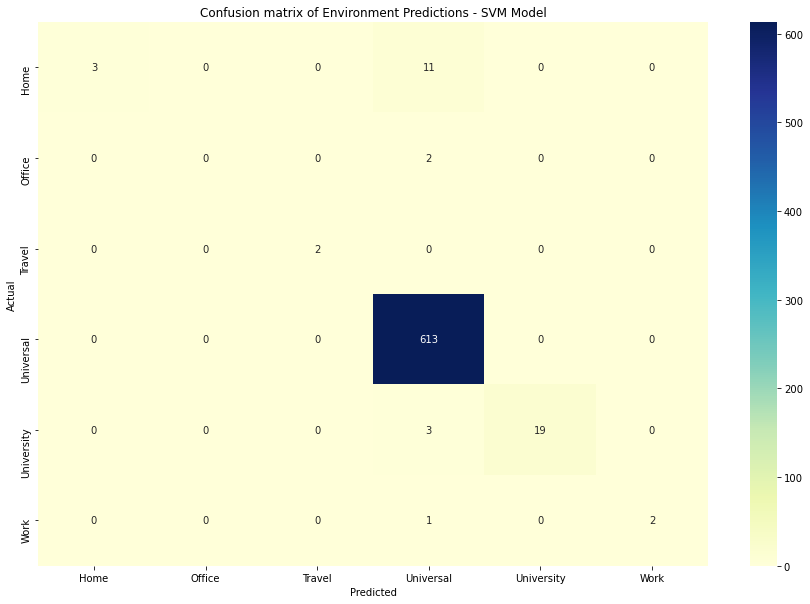

In [91]:
# Error Analysis 

conf_mat_env = confusion_matrix(y_test, y_pred_env, labels=np.unique(y_test))
conf_mat_env

cm = pd.DataFrame(conf_mat_env, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(cm, cmap="YlGnBu", annot= True, fmt='', ax=ax)
plt.title('Confusion matrix of Environment Predictions - SVM Model')

# Valence Detection Model and Analysis 

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Valence Distribution in Training Dataset'}>

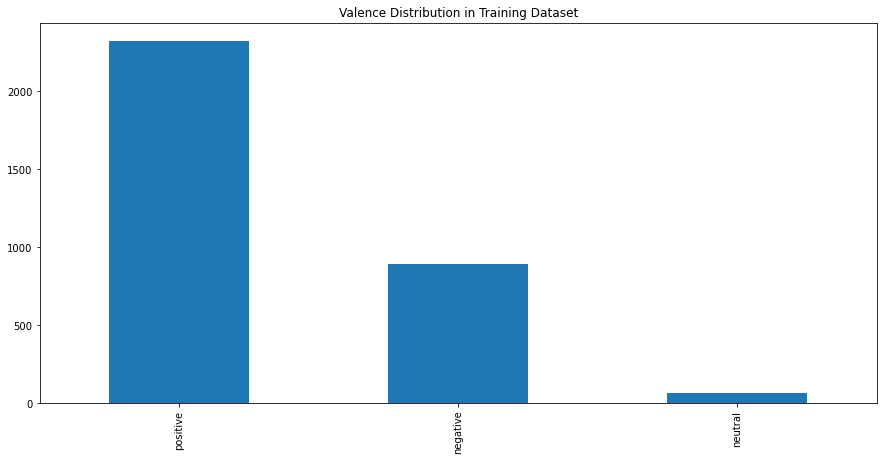

In [92]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
df_train["Valence"].value_counts().plot(kind="bar", title="Valence Distribution in Training Dataset")


In [93]:
# Valence Detection Model

x = df_train[["Review Body"]]
y = df_train[["Valence"]]
    
x=x.iloc[:,0]
y=y.iloc[:,:]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state =1, shuffle = True)

#X_train_tfidf, count_vect, tfidf_transformer = preprocess_text(x_train)
LR= linear_model.LogisticRegression()
LR.fit(X_train_tfidf, y_train.values)
LR.score(X_train_tfidf, y_train.values)
print("Accuracy for Valence detection model on training set (80% of total dataset) is :", acc)
    


#x_test_tfidf = count_vectorizer(x_test, count_vect, tfidf_transformer)
print("The full report for the Valence detection model on testing set ( 20% of the dataset ) is the below:")
y_pred_val = LR.predict(x_test_tfidf)
print(creport(y_test, y_pred_val))
    
    
filename_LR = 'LR_valence_model_2.sav'
pickle.dump(LR, open(filename_LR, 'wb'))

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for Valence detection model on training set (80% of total dataset) is : 0.9862700228832952
The full report for the Valence detection model on testing set ( 20% of the dataset ) is the below:
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87       192
     neutral       0.00      0.00      0.00        14
    positive       0.91      0.99      0.94       450

    accuracy                           0.91       656
   macro avg       0.62      0.60      0.61       656
weighted avg       0.90      0.91      0.90       656



/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipytho

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Confusion matrix of Environment Predictions - Linear Regression Model')

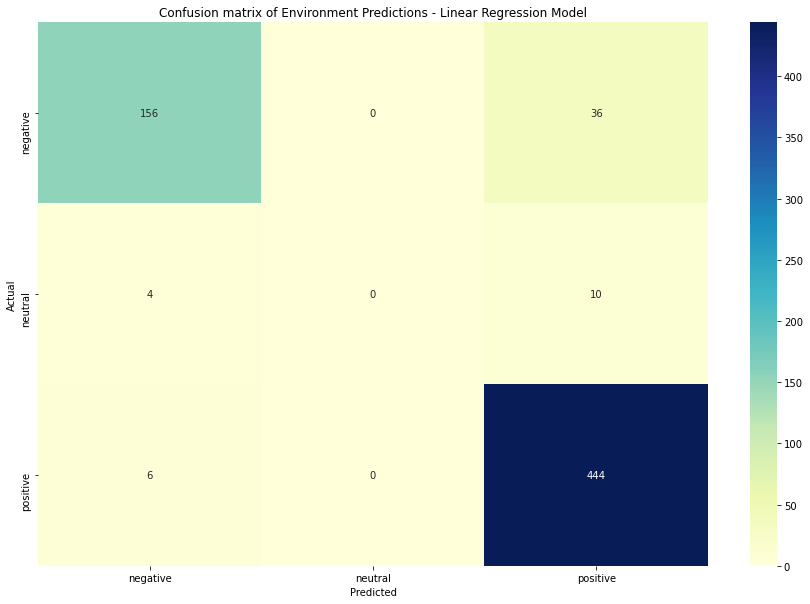

In [94]:
# Error Analysis 

conf_mat_val = confusion_matrix(y_test, y_pred_val, labels=np.unique(y_test))
conf_mat_val

cm = pd.DataFrame(conf_mat_val, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(cm, cmap="YlGnBu", annot= True, fmt='', ax=ax)
plt.title('Confusion matrix of Environment Predictions - Linear Regression Model')

# Object Detection Modal and Analysis

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-95-7c4261991f59>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Object"] = df_train["Object"].str.replace("http://linked.aub.edu.lb/actionrec/Thing/", "")


<AxesSubplot:title={'center':'Object Distribution in Training Dataset'}>

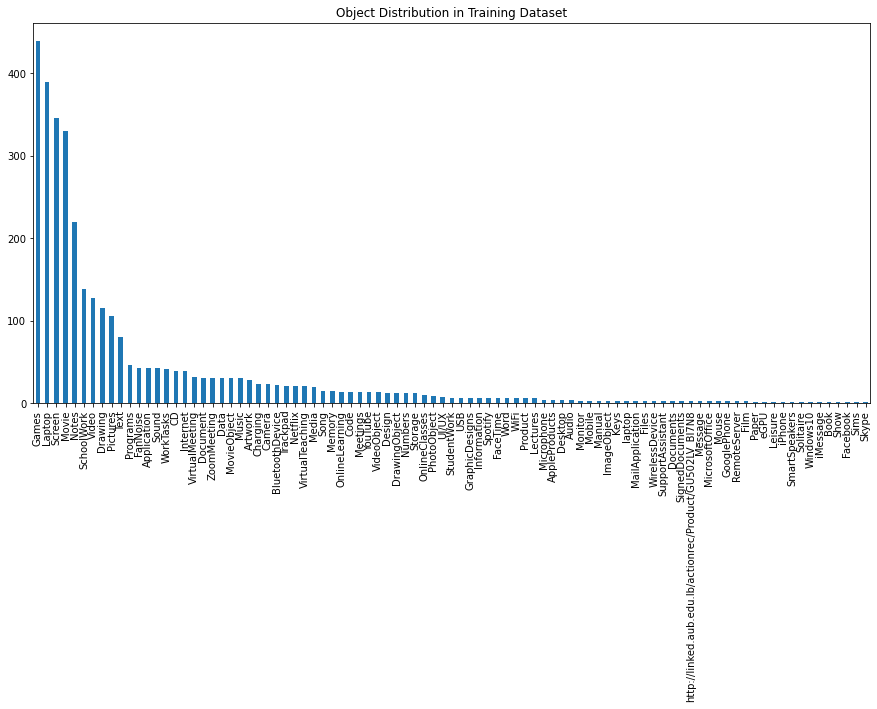

In [95]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
df_train["Object"] = df_train["Object"].str.replace("http://linked.aub.edu.lb/actionrec/Thing/", "")
df_train["Object"].value_counts().plot(kind="bar", title="Object Distribution in Training Dataset")


In [96]:
# Object Detection Model


x = df_train[["Review Body"]]
y = df_train[["Object"]]
    
x=x.iloc[:,0]
y=y.iloc[:,:]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state =1, shuffle = True)

#X_train_tfidf, count_vect, tfidf_transformer = preprocess_text(x_train)
clf= SVC(random_state = 0)
clf.fit(X_train_tfidf, y_train.values)
acc = clf.score(X_train_tfidf, y_train.values)
print("Accuracy for Object detection model on training set (80% of total dataset) is :", acc)
    

x_test_tfidf = count_vectorizer(x_test, count_vect, tfidf_transformer)
print("The full report for the Object detection model on testing set ( 20% of the dataset ) is the below:")
y_pred_obj = clf.predict(x_test_tfidf)
print(creport(y_test, y_pred_obj))
    
    
filename_clf = 'SVM_object_model_2.sav'
pickle.dump(clf, open(filename_clf, 'wb'))

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for Object detection model on training set (80% of total dataset) is : 0.7658276125095347
The full report for the Object detection model on testing set ( 20% of the dataset ) is the below:
                  precision    recall  f1-score   support

   AppleProducts       1.00      1.00      1.00         1
     Application       0.44      0.50      0.47         8
         Artwork       1.00      1.00      1.00         6
           Audio       0.00      0.00      0.00         2
 BluetoothDevice       1.00      0.80      0.89         5
              CD       0.90      1.00      0.95         9
          Camera       0.50      1.00      0.67         4
        Charging       0.00      0.00      0.00         3
            Code       1.00      1.00      1.00         4
            Data       0.83      0.50      0.62        10
          Design       1.00      1.00      1.00         4
         Desktop       0.00      0.00      0.00         1
        Document       0.00      0.00      0.00

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bothaina

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Confusion matrix of Object Predictions - SVM Model')

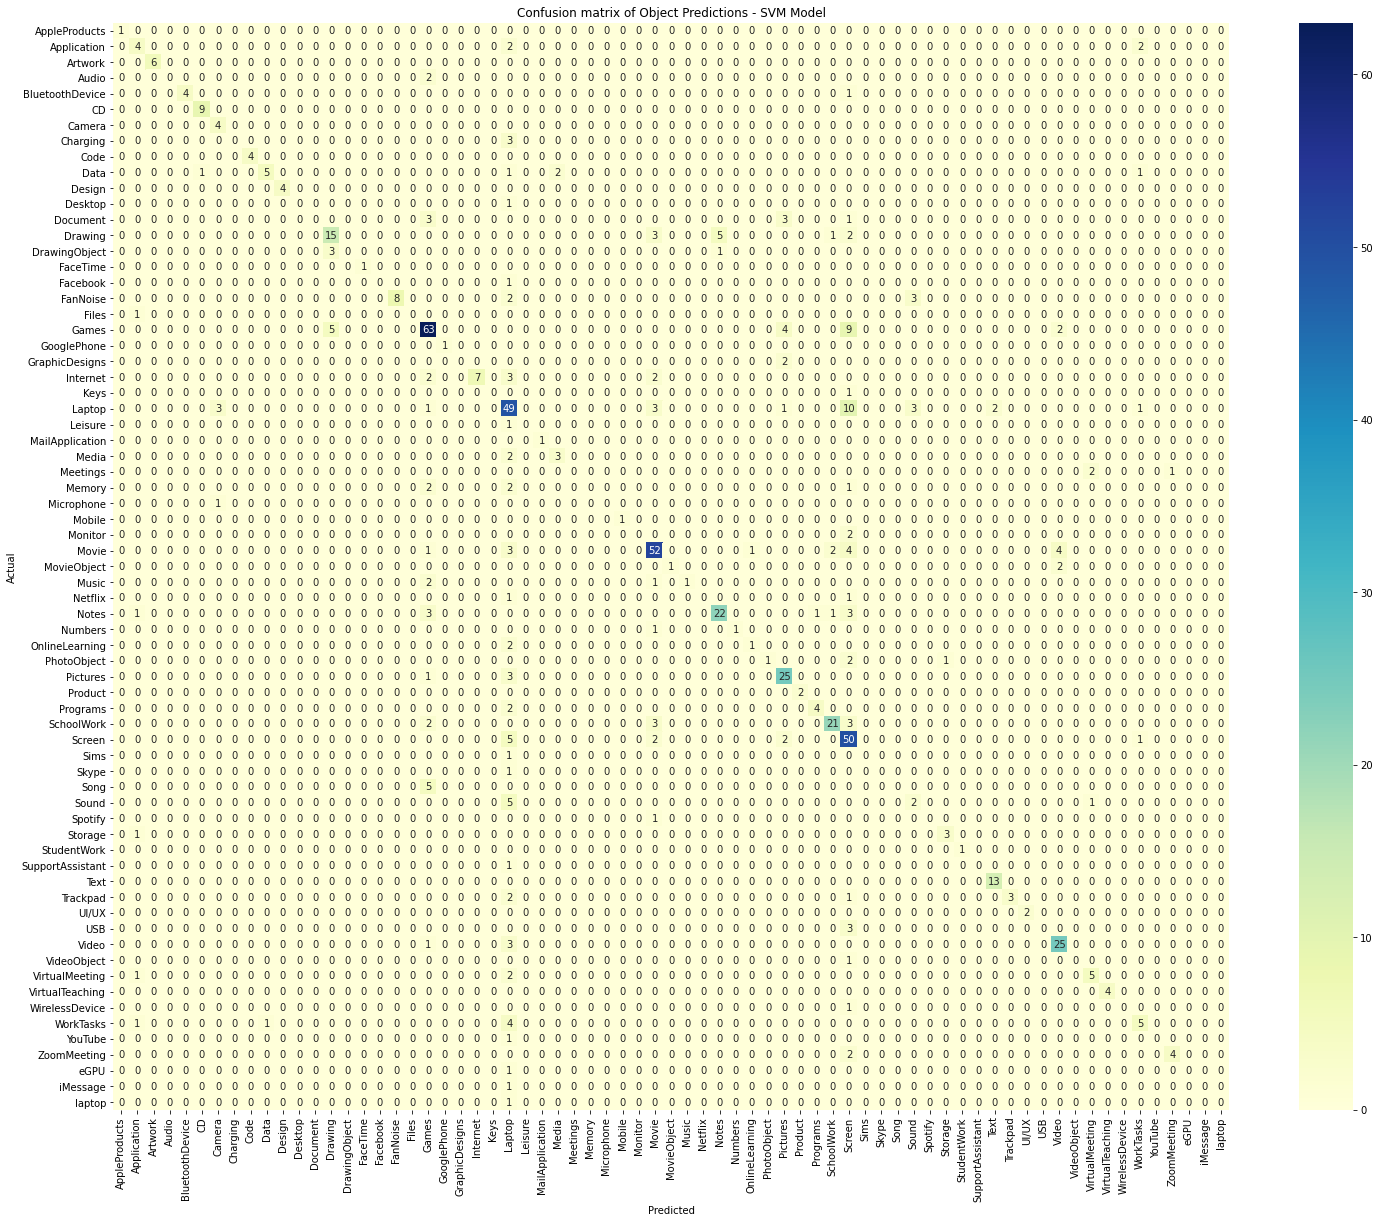

In [97]:
conf_mat_obj = confusion_matrix(y_test, y_pred_obj, labels=np.unique(y_test))
conf_mat_obj

cm = pd.DataFrame(conf_mat_obj, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(1, 1, figsize=(25, 20))
sns.heatmap(cm, cmap="YlGnBu", annot= True, fmt='', ax=ax)
plt.title('Confusion matrix of Object Predictions - SVM Model')

# New reviews section

In [10]:
# Get new reviews from product url 

import pandas as pd 
import requests
import json



url = "http://linked.aub.edu.lb:8585/ml"


#payload="{\"url\":\"https://www.bestbuy.com/site/reviews/microsoft-surface-laptop-studio--14-4-touch-screen--intel-core-i7-16gb-memory--nvidia-geforce-rtx-3050-ti-512gb-ssd-platinum/6478302?variant=A&intl=nosplash\"}"


#payload="{\"url\":\"https://www.bestbuy.com/site/reviews/lenovo-ideapad-duet-3-chromebook-11-0-2000x1200-touch-2-in-1-tablet-snapdragon-7cg2-4g-ram-128g-emmc-with-keyboard-misty-blue/6508240?variant=A&intl=nosplash\"}"

headers = {

  'Authorization': 'Basic dXNyOnBhc3M=',

  'Content-Type': 'application/json',

  'Cookie': 'session_id=8460d79fca0ceebde7b83960570e1db3ca181c18'

}


response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)
#data = json.loads(response.text)
#data = response.json()
#print(data)


<!DOCTYPE html PUBLIC
"-//W3C//DTD XHTML 1.0 Transitional//EN"
"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8"></meta>
    <title>500 Internal Server Error</title>
    <style type="text/css">
    #powered_by {
        margin-top: 20px;
        border-top: 2px solid black;
        font-style: italic;
    }

    #traceback {
        color: red;
    }
    </style>
</head>
    <body>
        <h2>500 Internal Server Error</h2>
        <p>The server encountered an unexpected condition which prevented it from fulfilling the request.</p>
        <pre id="traceback">Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/extruct/jsonld.py", line 35, in _extract_items
    data = json.loads(script, strict=False)
  File "/usr/local/lib/python3.6/json/__init__.py", line 367, in loads
    return cls(**kw).decode(s)
  File "/usr/local/lib/python3.6/json/decoder.py", line 339, in d

In [11]:

url = "http://linked.aub.edu.lb:8585/ml"


payload="{\"url\":\"https://www.bestbuy.com/site/reviews/microsoft-surface-laptop-studio--14-4-touch-screen--intel-core-i7-16gb-memory--nvidia-geforce-rtx-3050-ti-512gb-ssd-platinum/6478302?variant=A&intl=nosplash\"}"


#payload="{\"url\":\"https://www.bestbuy.com/site/reviews/lenovo-ideapad-duet-3-chromebook-11-0-2000x1200-touch-2-in-1-tablet-snapdragon-7cg2-4g-ram-128g-emmc-with-keyboard-misty-blue/6508240?variant=A&intl=nosplash\"}"

headers = {

  'Authorization': 'Basic dXNyOnBhc3M=',

  'Content-Type': 'application/json',

  'Cookie': 'session_id=8460d79fca0ceebde7b83960570e1db3ca181c18'

}


response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)
#data = json.loads(response.text)
#data = response.json()
#print(data)

{"microdata": [], "json-ld": [{"@context": "http://schema.org", "@type": "Product", "name": "Microsoft - Surface Laptop Studio \u2013 14.4\u201d Touch Screen \u2013 Intel Core i7 -16GB Memory \u2013 NVIDIA GeForce RTX 3050 Ti - 512GB SSD - Platinum", "url": "https://www.bestbuy.com/site/microsoft-surface-laptop-studio-14-4-touch-screen-intel-core-i7-16gb-memory-nvidia-geforce-rtx-3050-ti-512gb-ssd-platinum/6478302.p?skuId=6478302", "image": "https://pisces.bbystatic.com/image2/BestBuy_US/images/products/6478/6478302cv11d.jpg", "description": "Set your imagination free on the most powerful Surface Laptop, designed to light up the best of Windows 11. Boundary-pushing design lets you flex your creative muscle on the sleek 14.4\u201c\u2074 touchscreen, making seamless transitions from laptop to entertainment-ready stage to portable creative canvas, complete with built-in storage and charging for Surface Slim Pen 2* under the keyboard. Enjoy smooth gameplay, and draw, sketch and take notes 

In [3]:
data

{'microdata': [],
 'json-ld': [{'@context': 'http://schema.org',
   '@type': 'Product',
   'name': 'Microsoft - Surface Laptop Studio – 14.4” Touch Screen – Intel Core i7 -16GB Memory – NVIDIA GeForce RTX 3050 Ti - 512GB SSD - Platinum',
   'url': 'https://www.bestbuy.com/site/microsoft-surface-laptop-studio-14-4-touch-screen-intel-core-i7-16gb-memory-nvidia-geforce-rtx-3050-ti-512gb-ssd-platinum/6478302.p?skuId=6478302',
   'image': 'https://pisces.bbystatic.com/image2/BestBuy_US/images/products/6478/6478302cv11d.jpg',
   'description': 'Set your imagination free on the most powerful Surface Laptop, designed to light up the best of Windows 11. Boundary-pushing design lets you flex your creative muscle on the sleek 14.4“⁴ touchscreen, making seamless transitions from laptop to entertainment-ready stage to portable creative canvas, complete with built-in storage and charging for Surface Slim Pen 2* under the keyboard. Enjoy smooth gameplay, and draw, sketch and take notes like you would

In [251]:
df = pd.DataFrame.from_dict(data, orient="index")

data_product = df.iloc[1,:]


products = []
reviews = []

for i in data_product:
    if i != None:
        for key, value in i.items():
            if i["@type"] == "Product":
                products.append(i)
                break;
            else:
                if i["@type"] == "Review":
                    reviews.append(i)
                    break;



print(len(products))
print(len(reviews))

1
20


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
df_product = pd.DataFrame(products)
df_reviews = pd.DataFrame(reviews)


print(df_product)
print(df_reviews)

            @context    @type  \
0  http://schema.org  Product   

                                                name  \
0  Microsoft - Surface Laptop Studio – 14.4” Touc...   

                                                 url  \
0  https://www.bestbuy.com/site/microsoft-surface...   

                                               image  \
0  https://pisces.bbystatic.com/image2/BestBuy_US...   

                                         description      sku      model  \
0  Set your imagination free on the most powerful...  6478302  A1Y-00001   

                                     brand  \
0  {'@type': 'Thing', 'name': 'Microsoft'}   

                                     aggregateRating  \
0  {'@type': 'AggregateRating', 'ratingValue': 4....   

                                              offers  
0  {'@type': 'Offer', 'priceCurrency': 'USD', 'pr...  
              @context   @type  \
0   http://schema.org/  Review   
1   http://schema.org/  Review   
2   http://schema.org/ 

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:

df_product = df_product.rename(columns = {'name': 'product_name', '@type': 'type', '@context': 'context'})
df_product["brand"].apply(pd.Series)
df_product["aggregateRating"].apply(pd.Series)
df_product["offers"].apply(pd.Series)


df_product = pd.concat([df_product, df_product["brand"].apply(pd.Series)], axis=1)
df_product = df_product.rename(columns = {'name': 'brand_name'})
df_product = pd.concat([df_product, df_product["aggregateRating"].apply(pd.Series)], axis=1)
df_product = pd.concat([df_product, df_product["offers"].apply(pd.Series)], axis=1)
df_product = pd.concat([df_product, df_product["seller"].apply(pd.Series)], axis=1)
df_product = df_product.rename(columns = {'name': 'seller_name'})



df_product

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,context,type,product_name,url,image,description,sku,model,brand,aggregateRating,...,@type,ratingValue,reviewCount,@type,priceCurrency,price,availability,seller,@type,seller_name
0,http://schema.org,Product,Microsoft - Surface Laptop Studio – 14.4” Touc...,https://www.bestbuy.com/site/microsoft-surface...,https://pisces.bbystatic.com/image2/BestBuy_US...,Set your imagination free on the most powerful...,6478302,A1Y-00001,"{'@type': 'Thing', 'name': 'Microsoft'}","{'@type': 'AggregateRating', 'ratingValue': 4....",...,AggregateRating,4.6,304,Offer,USD,2099.99,http://schema.org/InStock,"{'@type': 'Organization', 'name': 'Best Buy'}",Organization,Best Buy


In [102]:
del df_product['@type']
del df_product['brand']
del df_product['aggregateRating']
del df_product['offers']
del df_product['seller']



/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
df_product

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,context,type,product_name,url,image,description,sku,model,brand_name,ratingValue,reviewCount,priceCurrency,price,availability,seller_name
0,http://schema.org,Product,Microsoft - Surface Laptop Studio – 14.4” Touc...,https://www.bestbuy.com/site/microsoft-surface...,https://pisces.bbystatic.com/image2/BestBuy_US...,Set your imagination free on the most powerful...,6478302,A1Y-00001,Microsoft,4.6,304,USD,2099.99,http://schema.org/InStock,Best Buy


In [104]:
df_reviews
df_reviews = df_reviews.rename(columns = {'name': 'review_name', '@type': 'type', '@context': 'context'})

df_reviews = pd.concat([df_reviews, df_reviews["itemReviewed"].apply(pd.Series)], axis=1)
df_reviews = df_reviews.rename(columns = {'name': 'product_name'})

df_reviews = pd.concat([df_reviews, df_reviews["author"].apply(pd.Series)], axis=1)
df_reviews = df_reviews.rename(columns = {'name': 'author_name'})

df_reviews = pd.concat([df_reviews, df_reviews["reviewRating"].apply(pd.Series)], axis=1)

df_reviews = pd.concat([df_reviews, df_reviews["publisher"].apply(pd.Series)], axis=1)
df_reviews = df_reviews.rename(columns = {'name': 'publisher_name'})

del df_reviews['@type']
del df_reviews['itemReviewed']
del df_reviews['author']
del df_reviews['reviewRating']
del df_reviews['publisher']


df_reviews

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name
0,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy
1,http://schema.org/,Review,Nice convertible,First surface product I have owned since all o...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Santi,5,5,Best Buy
2,http://schema.org/,Review,Best Laptop on the Market,This is by far the best laptop I have ever own...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Nick,5,5,Best Buy
3,http://schema.org/,Review,Best Surface To Date,I’ve owned the original Surface as well as a S...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Rettogo,5,5,Best Buy
4,http://schema.org/,Review,Intel Core i7 -16GB Memory – NVIDIA GeForce RT...,I WAS IN BETWEEN THE MACBOOK PRO AND THIS. I L...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Johnnycash,5,5,Best Buy
5,http://schema.org/,Review,Defective - DONT BUY IT,I bought it on 12/20/2022. Item arrived with a...,Microsoft - Surface Laptop Studio – 14.4” Touc...,GusBar,1,5,Best Buy
6,http://schema.org/,Review,A Good Cross between computer and tablet,This is a good option for anyone who wants bot...,Microsoft - Surface Laptop Studio – 14.4” Touc...,mbart553,5,5,Best Buy
7,http://schema.org/,Review,Super Good Laptop,good laptop for everything including drawing f...,Microsoft - Surface Laptop Studio – 14.4” Touc...,review,5,5,Best Buy
8,http://schema.org/,Review,Surface Laptop Channels Powerful Creativity,The Microsoft Surface Laptop Studio is a great...,Microsoft - Surface Laptop Studio – 14.4” Touc...,stoptheclocks,5,5,Best Buy
9,http://schema.org/,Review,"Spectacular, but not perfect","Ok, my wife or I have had Surface Pro Tablets/...",Microsoft - Surface Laptop Studio – 14.4” Touc...,3Tcubed,4,5,Best Buy


In [105]:
def count_vectorizer(annotation, count_vect, tfidf_transformer) -> float:
    
    annotation_counts=count_vect.transform(annotation)
    annotation_tfidf = tfidf_transformer.fit_transform(annotation_counts)
    annotation_tfidf= annotation_tfidf.toarray()
    return annotation_tfidf

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
#Agent Detection 
reviews = df_reviews[["reviewBody"]]
reviews=reviews.iloc[:,0]


#count_vect, tfidf_transformer = train_agent_detection_model()
reviews_tfidf = count_vectorizer(reviews, count_vect, tfidf_transformer)
filename_clf =  'SVM_agent_model_2.sav'
loaded_agent_detection_model = pickle.load(open(filename_clf, 'rb'))
agent = loaded_agent_detection_model.predict(reviews_tfidf)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-106-c5972bf17598>:9: ResourceWarning: unclosed file <_io.BufferedReader name='SVM_agent_model_2.sav'>
  loaded_agent_detection_model = pickle.load(open(filename_clf, 'rb'))


In [107]:
df_reviews["Agent"] = agent
print(df_reviews)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


               context    type  \
0   http://schema.org/  Review   
1   http://schema.org/  Review   
2   http://schema.org/  Review   
3   http://schema.org/  Review   
4   http://schema.org/  Review   
5   http://schema.org/  Review   
6   http://schema.org/  Review   
7   http://schema.org/  Review   
8   http://schema.org/  Review   
9   http://schema.org/  Review   
10  http://schema.org/  Review   
11  http://schema.org/  Review   
12  http://schema.org/  Review   
13  http://schema.org/  Review   
14  http://schema.org/  Review   
15  http://schema.org/  Review   
16  http://schema.org/  Review   
17  http://schema.org/  Review   
18  http://schema.org/  Review   
19  http://schema.org/  Review   

                                          review_name  \
0                         The Beautiful Laptop Studio   
1                                    Nice convertible   
2                           Best Laptop on the Market   
3                                Best Surface To Date   


In [108]:
# Environment Detection

#reviews_tfidf = count_vectorizer(reviews, count_vect, tfidf_transformer)
filename_env = 'SVM_environment_model_2.sav'
loaded_env_detection_model = pickle.load(open(filename_env, 'rb'))
environment = loaded_env_detection_model.predict(reviews_tfidf)

print(environment)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-108-818ee8b06959>:5: ResourceWarning: unclosed file <_io.BufferedReader name='SVM_environment_model_2.sav'>
  loaded_env_detection_model = pickle.load(open(filename_env, 'rb'))


['Universal' 'Universal' 'Universal' 'Universal' 'Universal' 'Universal'
 'Universal' 'Universal' 'Universal' 'Universal' 'Universal' 'Universal'
 'Universal' 'Universal' 'Universal' 'Universal' 'Universal' 'Universal'
 'Universal' 'Universal']


In [109]:
df_reviews["Environment"] = environment
print(df_reviews)

               context    type  \
0   http://schema.org/  Review   
1   http://schema.org/  Review   
2   http://schema.org/  Review   
3   http://schema.org/  Review   
4   http://schema.org/  Review   
5   http://schema.org/  Review   
6   http://schema.org/  Review   
7   http://schema.org/  Review   
8   http://schema.org/  Review   
9   http://schema.org/  Review   
10  http://schema.org/  Review   
11  http://schema.org/  Review   
12  http://schema.org/  Review   
13  http://schema.org/  Review   
14  http://schema.org/  Review   
15  http://schema.org/  Review   
16  http://schema.org/  Review   
17  http://schema.org/  Review   
18  http://schema.org/  Review   
19  http://schema.org/  Review   

                                          review_name  \
0                         The Beautiful Laptop Studio   
1                                    Nice convertible   
2                           Best Laptop on the Market   
3                                Best Surface To Date   


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
# Valence Detection

filename_LR = 'LR_valence_model_2.sav'
loaded_valence_detection_model = pickle.load(open(filename_LR, 'rb'))
valence = loaded_valence_detection_model.predict(reviews_tfidf)
print(valence)

['positive' 'positive' 'positive' 'positive' 'positive' 'negative'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive']


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-110-5a26342d5b61>:4: ResourceWarning: unclosed file <_io.BufferedReader name='LR_valence_model_2.sav'>
  loaded_valence_detection_model = pickle.load(open(filename_LR, 'rb'))


In [111]:
df_reviews["Valence"] = valence
print(df_reviews)

               context    type  \
0   http://schema.org/  Review   
1   http://schema.org/  Review   
2   http://schema.org/  Review   
3   http://schema.org/  Review   
4   http://schema.org/  Review   
5   http://schema.org/  Review   
6   http://schema.org/  Review   
7   http://schema.org/  Review   
8   http://schema.org/  Review   
9   http://schema.org/  Review   
10  http://schema.org/  Review   
11  http://schema.org/  Review   
12  http://schema.org/  Review   
13  http://schema.org/  Review   
14  http://schema.org/  Review   
15  http://schema.org/  Review   
16  http://schema.org/  Review   
17  http://schema.org/  Review   
18  http://schema.org/  Review   
19  http://schema.org/  Review   

                                          review_name  \
0                         The Beautiful Laptop Studio   
1                                    Nice convertible   
2                           Best Laptop on the Market   
3                                Best Surface To Date   


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
# Object Detection 

filename_obj = 'SVM_object_model_2.sav'
loaded_obj_detection_model = pickle.load(open(filename_obj, 'rb'))
obj = loaded_obj_detection_model.predict(reviews_tfidf)
print(obj)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-112-7384660f722d>:4: ResourceWarning: unclosed file <_io.BufferedReader name='SVM_object_model_2.sav'>
  loaded_obj_detection_model = pickle.load(open(filename_obj, 'rb'))


['Laptop' 'Laptop' 'Games' 'Laptop' 'Games' 'Laptop' 'Laptop' 'Games'
 'Games' 'Screen' 'Pictures' 'Games' 'Media' 'Screen' 'Laptop' 'Games'
 'Games' 'Laptop' 'Laptop' 'Laptop']


In [113]:
df_reviews["Object"] = obj
print(df_reviews)

               context    type  \
0   http://schema.org/  Review   
1   http://schema.org/  Review   
2   http://schema.org/  Review   
3   http://schema.org/  Review   
4   http://schema.org/  Review   
5   http://schema.org/  Review   
6   http://schema.org/  Review   
7   http://schema.org/  Review   
8   http://schema.org/  Review   
9   http://schema.org/  Review   
10  http://schema.org/  Review   
11  http://schema.org/  Review   
12  http://schema.org/  Review   
13  http://schema.org/  Review   
14  http://schema.org/  Review   
15  http://schema.org/  Review   
16  http://schema.org/  Review   
17  http://schema.org/  Review   
18  http://schema.org/  Review   
19  http://schema.org/  Review   

                                          review_name  \
0                         The Beautiful Laptop Studio   
1                                    Nice convertible   
2                           Best Laptop on the Market   
3                                Best Surface To Date   


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Action Detection Multi-label model and analysis 

Action and feature detection will take place on sentence levela nd not the full review text. We might have multiple actions in one senetence and the review text might refernce to multiple features of the product. A multi label classification model will be used to detect the action in each sentence. While for the features we will be using the cosine similarity technique which scores for each senetnce the features that might have close meaning. 

In [114]:
df_reviews = df_reviews.reset_index()
df_reviews = df_reviews.rename(columns={"index":"Review id"})
df_reviews['Review id'] = df_reviews.index + 1000
df_reviews

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review id,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name,Agent,Environment,Valence,Object
0,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop
1,1001,http://schema.org/,Review,Nice convertible,First surface product I have owned since all o...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Santi,5,5,Best Buy,Person,Universal,positive,Laptop
2,1002,http://schema.org/,Review,Best Laptop on the Market,This is by far the best laptop I have ever own...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Nick,5,5,Best Buy,Person,Universal,positive,Games
3,1003,http://schema.org/,Review,Best Surface To Date,I’ve owned the original Surface as well as a S...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Rettogo,5,5,Best Buy,Person,Universal,positive,Laptop
4,1004,http://schema.org/,Review,Intel Core i7 -16GB Memory – NVIDIA GeForce RT...,I WAS IN BETWEEN THE MACBOOK PRO AND THIS. I L...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Johnnycash,5,5,Best Buy,Person,Universal,positive,Games
5,1005,http://schema.org/,Review,Defective - DONT BUY IT,I bought it on 12/20/2022. Item arrived with a...,Microsoft - Surface Laptop Studio – 14.4” Touc...,GusBar,1,5,Best Buy,Person,Universal,negative,Laptop
6,1006,http://schema.org/,Review,A Good Cross between computer and tablet,This is a good option for anyone who wants bot...,Microsoft - Surface Laptop Studio – 14.4” Touc...,mbart553,5,5,Best Buy,Person,Universal,positive,Laptop
7,1007,http://schema.org/,Review,Super Good Laptop,good laptop for everything including drawing f...,Microsoft - Surface Laptop Studio – 14.4” Touc...,review,5,5,Best Buy,Student,Universal,positive,Games
8,1008,http://schema.org/,Review,Surface Laptop Channels Powerful Creativity,The Microsoft Surface Laptop Studio is a great...,Microsoft - Surface Laptop Studio – 14.4” Touc...,stoptheclocks,5,5,Best Buy,Person,Universal,positive,Games
9,1009,http://schema.org/,Review,"Spectacular, but not perfect","Ok, my wife or I have had Surface Pro Tablets/...",Microsoft - Surface Laptop Studio – 14.4” Touc...,3Tcubed,4,5,Best Buy,Person,Universal,positive,Screen


In [115]:
# the first step is to split the review text into snetences, 
#and classify the sentences as informative or non-informative. 

import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

review_sentences = []
for review in df_reviews["reviewBody"]:
  review_sent = tokenizer.tokenize(str(review))
  review_sentences.append(review_sent)

df_reviews["review sentences"] = review_sentences
#print(review_sentences)


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /Users/bothainaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [116]:
df_splitted_review = df_reviews["review sentences"].apply(pd.Series).stack().rename("review sentences").reset_index()
#df_split
print("The number of rows of the dataset set of review sentences splitted is:", df_splitted_review.shape[0])

The number of rows of the dataset set of review sentences splitted is: 457


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [117]:
df_final = pd.merge(df_splitted_review,df_reviews,left_on='level_0',right_index=True, suffixes=(['','_old']))[df_reviews.columns]

df_final

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review id,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name,Agent,Environment,Valence,Object,review sentences
0,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I finally decided to take the plunge and get t...
1,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I'll start with the challenges:\nBattery life ...
2,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"I get about 6 hours, from surfing, light photo..."
3,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"6 hours is okay, but I have an MBP 16"" and it ..."
4,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,Price: \nRidiculously expensive compared to ot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,"I don’t feel that any quality, speed, or funct..."
453,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,This is definitely the best windows machine I ...
454,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The build quality is exceptional and feels ver...
455,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The only thing that isn’t up to par with my pr...


In [118]:
x = df_final["review sentences"]

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
print(x)

0      I finally decided to take the plunge and get t...
1      I'll start with the challenges:\nBattery life ...
2      I get about 6 hours, from surfing, light photo...
3      6 hours is okay, but I have an MBP 16" and it ...
4      Price: \nRidiculously expensive compared to ot...
                             ...                        
452    I don’t feel that any quality, speed, or funct...
453    This is definitely the best windows machine I ...
454    The build quality is exceptional and feels ver...
455    The only thing that isn’t up to par with my pr...
456    Overall, I am really impressed and satisfied w...
Name: review sentences, Length: 457, dtype: object


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
# Train the action flag model. The dataset is manually done and not from sparql. 
2


def action_no_action_model(x, count_vect, tfidf_transformer ):
     filename_svm = 'SVM_action_noaction_model.sav'
     annotations_tfidf = count_vectorizer(x, count_vect, tfidf_transformer)
     loaded_model_svm = pickle.load(open(filename_svm, 'rb'))
     result_svm = loaded_model_svm.predict(annotations_tfidf)
     proba_svm = loaded_model_svm.predict_proba(annotations_tfidf)

     return result_svm, proba_svm

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
count_vect, tfidf_transformer = train_model_action_flag()

result_action_flag, proba_action = action_no_action_model(x,count_vect, tfidf_transformer)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-120-2612db26aba6>:27: ResourceWarning: unclosed file <_io.BufferedWriter name='SVM_action_noaction_model.sav'>
  pickle.dump(clf, open(filename_svm, 'wb'))
<ipython-input-120-2612db26aba6>:35: ResourceWarning: unclosed file <_io.BufferedReader name='SVM_action_noaction_model.sav'>
  loaded_model_svm = pickle.load(open(filename_svm, 'r

In [122]:
print(result_action_flag)
print(proba_action[:,0])

#proba = round(proba_svm[0][0], 1) * 100

['Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'No Action Found'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Action Exist' 'Action Exist' 'Action Exist'
 'Action Exist' 'Acti

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
df_final["Action Flag"] = result_action_flag

probas = []
for i in proba_action[:,0]:
    proba = round(i, 2) * 100
    probas.append(proba)
    
df_final["Action Probability"] = probas  


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
df_final

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review id,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name,Agent,Environment,Valence,Object,review sentences,Action Flag,Action Probability
0,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I finally decided to take the plunge and get t...,Action Exist,66.0
1,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I'll start with the challenges:\nBattery life ...,Action Exist,96.0
2,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"I get about 6 hours, from surfing, light photo...",Action Exist,88.0
3,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"6 hours is okay, but I have an MBP 16"" and it ...",Action Exist,98.0
4,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,Price: \nRidiculously expensive compared to ot...,Action Exist,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,"I don’t feel that any quality, speed, or funct...",Action Exist,63.0
453,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,This is definitely the best windows machine I ...,Action Exist,46.0
454,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The build quality is exceptional and feels ver...,Action Exist,28.0
455,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The only thing that isn’t up to par with my pr...,Action Exist,69.0


In [125]:
filename_multi_action = 'multi_label_action_model.sav'

loaded_model_multi_action = pickle.load(open(filename_multi_action, 'rb'))
result_multi_action = loaded_model_multi_action.predict(x)
print(result_multi_action)

[30 30 16  6 16 25 43 21 15 57  6  5 49 51 43  8 15 57 46 51 54 51 30 16
 30 26  6 16 54  8  6 19  8 43 26 30 30 19 54 55 54 19 21 46 30 55 51  6
  5 55 51  5 43 30  5 51 54  6 55 43 54 30 15 55 50  5 54 51 54 51 57 16
 57  5  5 51 51  5  5  5 30 16 15  8  5 46 15 16 15 15 30  6 30 52 54 51
 25 46 30  5  8 30 53 49 46 16 15 15 30 15 30 55 30 40 54 30 54  5 51 55
 30  5 16  6 54 21 51 28 25 30  6 46 30 55  6 25 46  5 43  5  5 15 57 15
 57 57 43 29 15 51 46 16 25 30 16 15 30 46 15 55 30 30 55  5 30 46 30 30
  5 19 47 20  5 30 15 43 15 15  6 15 46 15 57 57  5 43 51  5 15  5 51 30
 16  6  7  6  6  5 30 30 51 46  6  8 16 35 54  5  6  6 51 57 15 46  6 51
 51 55 30 57  5  5 55 16 30 15 25  5 54 54 30 25 57 30 15 16 15 16  5 30
 20 46 15 30  5 16 16 57 30 57 30 30 30 16 30  6  5  8 46  8 15  5 57 21
 51 16 30 28 52 52 16 30 57 51 15 51  6 15 30 30 54 29 54 25 15  8 19 15
 57  6  6 57 46 15 30 54 30 55 51  6 51 57 46  8 16 16 15 54 15  5 30  8
 30 15 54 57 30  5 15  5 30 30 46 30 46 15 19 54 15

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.p

In [126]:
from sklearn import preprocessing
clf = preprocessing.LabelBinarizer()
clf.fit(result_multi_action)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LabelBinarizer()

In [127]:
pred_array = clf.transform(result_multi_action)
pred_array

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [128]:
actions = ['Action_AnimateAction', 'Action_BackupAction', 'Action_BendAction',
       'Action_BrowseAction', 'Action_CallAction', 'Action_CarryAction',
       'Action_ChargeAction', 'Action_ClickAction', 'Action_ConnectAction',
       'Action_CrackAction', 'Action_CreateAction', 'Action_DesignAction',
       'Action_DevelopAction', 'Action_DisableAction', 'Action_DownloadAction',
       'Action_DrawAction', 'Action_EditAction', 'Action_ExerciseAction',
       'Action_FilmAction', 'Action_FoldAction', 'Action_HearAction',
       'Action_HoldAction', 'Action_InstallAction', 'Action_IntegrateAction',
       'Action_InteractAction', 'Action_ListenAction', 'Action_LoadAction',
       'Action_MeetAction', 'Action_MultitaskAction', 'Action_NavigateAction',
       'Action_PlayAction', 'Action_ProcessAction', 'Action_ReadAction',
       'Action_RecordAction', 'Action_ResizeAction', 'Action_RunAction',
       'Action_ScanAction', 'Action_ScrollAction', 'Action_SelectAction',
       'Action_SellAction', 'Action_SetupAction', 'Action_ShutDownAction',
       'Action_SignAction', 'Action_StartAction', 'Action_StoreAction',
       'Action_StreamAction', 'Action_StudyAction', 'Action_TeachAction',
       'Action_TextAction', 'Action_TouchAction', 'Action_TransferAction',
       'Action_TypeAction', 'Action_UnlockAction', 'Action_UpgradeAction',
       'Action_ViewAction', 'Action_WatchAction', 'Action_WorkAction',
       'Action_WriteAction']
id_action = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57]


dict_actions = dict(zip(id_action, actions))
dict_actions

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 'Action_AnimateAction',
 1: 'Action_BackupAction',
 2: 'Action_BendAction',
 3: 'Action_BrowseAction',
 4: 'Action_CallAction',
 5: 'Action_CarryAction',
 6: 'Action_ChargeAction',
 7: 'Action_ClickAction',
 8: 'Action_ConnectAction',
 9: 'Action_CrackAction',
 10: 'Action_CreateAction',
 11: 'Action_DesignAction',
 12: 'Action_DevelopAction',
 13: 'Action_DisableAction',
 14: 'Action_DownloadAction',
 15: 'Action_DrawAction',
 16: 'Action_EditAction',
 17: 'Action_ExerciseAction',
 18: 'Action_FilmAction',
 19: 'Action_FoldAction',
 20: 'Action_HearAction',
 21: 'Action_HoldAction',
 22: 'Action_InstallAction',
 23: 'Action_IntegrateAction',
 24: 'Action_InteractAction',
 25: 'Action_ListenAction',
 26: 'Action_LoadAction',
 27: 'Action_MeetAction',
 28: 'Action_MultitaskAction',
 29: 'Action_NavigateAction',
 30: 'Action_PlayAction',
 31: 'Action_ProcessAction',
 32: 'Action_ReadAction',
 33: 'Action_RecordAction',
 34: 'Action_ResizeAction',
 35: 'Action_RunAction',
 36: 'Action

In [129]:
pred_actions = []
for i in result_multi_action:
    for j in dict_actions:
      if i == j:
         pred_actions.append(dict_actions[j])


len(pred_actions)

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


457

In [130]:
df_pred_actions = pd.DataFrame(pred_actions, columns = {"Actions"})

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
from tables import index
df_review_with_action = pd.concat([df_final.reset_index(drop=True), df_pred_actions.reset_index(drop = True)], axis=1)
df_review_with_action

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review id,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name,Agent,Environment,Valence,Object,review sentences,Action Flag,Action Probability,Actions
0,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I finally decided to take the plunge and get t...,Action Exist,66.0,Action_PlayAction
1,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I'll start with the challenges:\nBattery life ...,Action Exist,96.0,Action_PlayAction
2,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"I get about 6 hours, from surfing, light photo...",Action Exist,88.0,Action_EditAction
3,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"6 hours is okay, but I have an MBP 16"" and it ...",Action Exist,98.0,Action_ChargeAction
4,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,Price: \nRidiculously expensive compared to ot...,Action Exist,61.0,Action_EditAction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,"I don’t feel that any quality, speed, or funct...",Action Exist,63.0,Action_ChargeAction
453,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,This is definitely the best windows machine I ...,Action Exist,46.0,Action_TouchAction
454,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The build quality is exceptional and feels ver...,Action Exist,28.0,Action_UpgradeAction
455,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The only thing that isn’t up to par with my pr...,Action Exist,69.0,Action_ChargeAction


# Feature Extraction from the annotation.

In [132]:
# Feature Matching using Cosine similarity

#Convert review sentence into words 

def convert_review(string):
    return (string.split())


review_lists = []
for i in df_review_with_action["review sentences"]:
  review_splitted = convert_review(i)
  review_lists.append(review_splitted)
  
df_review_with_action["review_into_words"] = review_lists
print(df_review_with_action["review_into_words"]) 

0      [I, finally, decided, to, take, the, plunge, a...
1      [I'll, start, with, the, challenges:, Battery,...
2      [I, get, about, 6, hours,, from, surfing,, lig...
3      [6, hours, is, okay,, but, I, have, an, MBP, 1...
4      [Price:, Ridiculously, expensive, compared, to...
                             ...                        
452    [I, don’t, feel, that, any, quality,, speed,, ...
453    [This, is, definitely, the, best, windows, mac...
454    [The, build, quality, is, exceptional, and, fe...
455    [The, only, thing, that, isn’t, up, to, par, w...
456    [Overall,, I, am, really, impressed, and, sati...
Name: review_into_words, Length: 457, dtype: object


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
 
ps = PorterStemmer()


review_stemmed = []
for review in df_review_with_action["review_into_words"]:
    stemmed_words = []
    for word in review:
         w = ps.stem(word)
         stemmed_words.append(w)
    review_stemmed.append(stemmed_words)


print(review_stemmed)
df_review_with_action["review_words_stemmed"] = review_stemmed

[['i', 'final', 'decid', 'to', 'take', 'the', 'plung', 'and', 'get', 'thi', 'beaut-', 'the', 'microsoft', '-', 'surfac', 'laptop', 'studio', 'i7,', '16gb', 'ram', 'with', 'the', '512', 'ssd,', 'and', 'i', 'love', 'it.'], ["i'll", 'start', 'with', 'the', 'challenges:', 'batteri', 'life', 'leav', 'a', 'bit', 'to', 'be', 'desired.'], ['i', 'get', 'about', '6', 'hours,', 'from', 'surfing,', 'light', 'photo', 'editing,', 'and', 'gener', 'product', 'work.'], ['6', 'hour', 'is', 'okay,', 'but', 'i', 'have', 'an', 'mbp', '16"', 'and', 'it', 'ha', '2-day', 'batteri', 'life.'], ['price:', 'ridicul', 'expens', 'compar', 'to', 'other', 'in', 'it', 'class.'], ['enough', 'said.'], ['ports:', 'i', 'like', 'ports,', 'but', 'i', 'have', 'realiz', 'that', 'mani', 'laptop', 'are', 'be', 'made', 'without', 'legaci', 'usb-a', 'ports,', 'so', 'i', 'guess', 'i', 'have', 'to', 'adjust.'], ['instead,', 'i', 'decid', 'to', 'upgrad', 'my', 'ssd', 'from', '512', 'gb', 'to', '1', 'tb,', 'which', 'wa', 'surprisingl

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:

df_train["Feature"] = df_train["Feature"].str.replace("http://linked.aub.edu.lb/actionrec/Feature/", "")
feature_list = df_train["Feature"].unique()
feature_list_lower = []
for i in feature_list:
  i = i.lower()
  feature_list_lower.append(i)

print(feature_list_lower)

['screenresolution', 'graphicscard', 'performance', 'fps', 'screenquality', 'processingpower', 'lightweight', 'screenrefreshrate', 'cpu', 'speed', 'batterylife', 'fans', 'discdrive', 'pairxboxcontroller', 'camera', 'screensize', 'applepencil', 'logitechpencil', 'splitscreen', 'wirelesskeyboard', 'size', 'programs', 'attachablekeyboard', 'multitask', 'bigsur', 'memory', 'speakers', 'operatingsystem', 'ssd', 'wordprocessing', 'bluetooth', 'keyboard', 'tabletfunction', 'touchscreen', 'microphone', 'processor', 'powersettings', 'hinges', 'wirelessconnection', 'touchpad', 'wifi', 'ports', 'battery', 'googleplaystore', 'stylus', 'harddrive', 'sdcardslot', 'trackpad', 'screen', 'screenbrightness', 'cddrive', 'cables', 'powerbutton', 'privacymode', 'igpu', 'fingerprintscanner', 'supportassistant', 'camerabutton', 'microphonebutton', 'gpu', 'charger', 'weight', 'tr', 'internaldrive', 'microsoft', 'fan', 'numerickeypad', 'cortana', 'sleepmode', 'openbox', 'surfaceslimpen', 'windowshello', 'spen'

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-134-0b22707f78b6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["Feature"] = df_train["Feature"].str.replace("http://linked.aub.edu.lb/actionrec/Feature/", "")


In [135]:
# Cosine similarity method with a threshold 80% to inquire a good batch of reasonable matching features to the review sentences. 

def word2vec(word):
    from collections import Counter
    from math import sqrt

    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]


# Features Extraction 


features_extracted =[]
scores_extracted = []

for review in df_review_with_action["review_words_stemmed"]:
  features = []
  scores = []
  for word in review:
    for key in feature_list_lower:
      try:
        res = cosdis(word2vec(word), word2vec(key))
        if res != 0:
          features.append(key)
          scores.append(res)
      except IndexError:
        pass
    #print(features)
    #print(scores)
  features_extracted.append(features)
  scores_extracted.append(scores)


#print(features_extracted)
#print(scores_extracted)


import operator 
from heapq import nlargest
  
list_dict =[]
for i in range(len(features_extracted)):
  dictionary = dict(zip(features_extracted[i], scores_extracted[i]))
  top_5_features = nlargest(1, dictionary, key = dictionary.get)[0]
  list_dict.append(top_5_features)

list_dict




df_review_with_action["Features"] = list_dict

print(df_review_with_action["Features"])




/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                     fan
1               discdrive
2                     cpu
3                      tr
4                  cables
              ...        
452                weight
453           applepencil
454    wirelessconnection
455                   fan
456           applepencil
Name: Features, Length: 457, dtype: object


In [136]:
# Ability field 
list_ability =[]
for i in df_review_with_action["Actions"]:

    ability = i.replace("Action", "Ability")
    list_ability.append(ability)

df_review_with_action["Ability"] = list_ability
df_review_with_action["Ability"]

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         Ability_PlayAbility
1         Ability_PlayAbility
2         Ability_EditAbility
3       Ability_ChargeAbility
4         Ability_EditAbility
                ...          
452     Ability_ChargeAbility
453      Ability_TouchAbility
454    Ability_UpgradeAbility
455     Ability_ChargeAbility
456       Ability_PlayAbility
Name: Ability, Length: 457, dtype: object

In [137]:
df_review_with_action["Ability"] = df_review_with_action["Ability"].str.replace("Ability_", "")
df_review_with_action["Actions"] = df_review_with_action["Actions"].str.replace("Action_", "")

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
df_review_with_action



/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review id,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name,...,Valence,Object,review sentences,Action Flag,Action Probability,Actions,review_into_words,review_words_stemmed,Features,Ability
0,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,...,positive,Laptop,I finally decided to take the plunge and get t...,Action Exist,66.0,PlayAction,"[I, finally, decided, to, take, the, plunge, a...","[i, final, decid, to, take, the, plung, and, g...",fan,PlayAbility
1,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,...,positive,Laptop,I'll start with the challenges:\nBattery life ...,Action Exist,96.0,PlayAction,"[I'll, start, with, the, challenges:, Battery,...","[i'll, start, with, the, challenges:, batteri,...",discdrive,PlayAbility
2,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,...,positive,Laptop,"I get about 6 hours, from surfing, light photo...",Action Exist,88.0,EditAction,"[I, get, about, 6, hours,, from, surfing,, lig...","[i, get, about, 6, hours,, from, surfing,, lig...",cpu,EditAbility
3,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,...,positive,Laptop,"6 hours is okay, but I have an MBP 16"" and it ...",Action Exist,98.0,ChargeAction,"[6, hours, is, okay,, but, I, have, an, MBP, 1...","[6, hour, is, okay,, but, i, have, an, mbp, 16...",tr,ChargeAbility
4,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,...,positive,Laptop,Price: \nRidiculously expensive compared to ot...,Action Exist,61.0,EditAction,"[Price:, Ridiculously, expensive, compared, to...","[price:, ridicul, expens, compar, to, other, i...",cables,EditAbility
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,...,positive,Laptop,"I don’t feel that any quality, speed, or funct...",Action Exist,63.0,ChargeAction,"[I, don’t, feel, that, any, quality,, speed,, ...","[i, don’t, feel, that, ani, quality,, speed,, ...",weight,ChargeAbility
453,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,...,positive,Laptop,This is definitely the best windows machine I ...,Action Exist,46.0,TouchAction,"[This, is, definitely, the, best, windows, mac...","[thi, is, definit, the, best, window, machin, ...",applepencil,TouchAbility
454,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,...,positive,Laptop,The build quality is exceptional and feels ver...,Action Exist,28.0,UpgradeAction,"[The, build, quality, is, exceptional, and, fe...","[the, build, qualiti, is, except, and, feel, v...",wirelessconnection,UpgradeAbility
455,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,...,positive,Laptop,The only thing that isn’t up to par with my pr...,Action Exist,69.0,ChargeAction,"[The, only, thing, that, isn’t, up, to, par, w...","[the, onli, thing, that, isn’t, up, to, par, w...",fan,ChargeAbility


In [139]:
df_review_with_action.columns

/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Review id', 'context', 'type', 'review_name', 'reviewBody',
       'product_name', 'author_name', 'ratingValue', 'bestRating',
       'publisher_name', 'Agent', 'Environment', 'Valence', 'Object',
       'review sentences', 'Action Flag', 'Action Probability', 'Actions',
       'review_into_words', 'review_words_stemmed', 'Features', 'Ability'],
      dtype='object')

In [140]:
df_final_new_reviews = df_review_with_action[['Review id', 'context', 'type', 'review_name', 'reviewBody',
       'product_name', 'author_name', 'ratingValue', 'bestRating',
       'publisher_name', 'Agent', 'Environment', 'Valence', 'Object',
       'review sentences', 'Action Flag', 'Action Probability', 'Actions',
        'Features', 'Ability']]


df_final_new_reviews


/Users/bothainaa/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Review id,context,type,review_name,reviewBody,product_name,author_name,ratingValue,bestRating,publisher_name,Agent,Environment,Valence,Object,review sentences,Action Flag,Action Probability,Actions,Features,Ability
0,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I finally decided to take the plunge and get t...,Action Exist,66.0,PlayAction,fan,PlayAbility
1,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,I'll start with the challenges:\nBattery life ...,Action Exist,96.0,PlayAction,discdrive,PlayAbility
2,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"I get about 6 hours, from surfing, light photo...",Action Exist,88.0,EditAction,cpu,EditAbility
3,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,"6 hours is okay, but I have an MBP 16"" and it ...",Action Exist,98.0,ChargeAction,tr,ChargeAbility
4,1000,http://schema.org/,Review,The Beautiful Laptop Studio,I finally decided to take the plunge and get t...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Great,4,5,Best Buy,Person,Universal,positive,Laptop,Price: \nRidiculously expensive compared to ot...,Action Exist,61.0,EditAction,cables,EditAbility
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,"I don’t feel that any quality, speed, or funct...",Action Exist,63.0,ChargeAction,weight,ChargeAbility
453,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,This is definitely the best windows machine I ...,Action Exist,46.0,TouchAction,applepencil,TouchAbility
454,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The build quality is exceptional and feels ver...,Action Exist,28.0,UpgradeAction,wirelessconnection,UpgradeAbility
455,1019,http://schema.org/,Review,Apple —&gt; Surface,This laptop is really nice. I have been an App...,Microsoft - Surface Laptop Studio – 14.4” Touc...,Listener,5,5,Best Buy,Person,Universal,positive,Laptop,The only thing that isn’t up to par with my pr...,Action Exist,69.0,ChargeAction,fan,ChargeAbility
